In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Naver 금융 사이트에서 시계열 데이터인 주식 데이터를 가져와서 분석하고자 한다.

### Crawling 방법 1. URL 이용하기
#### 1. 한국 거래소(krx)에서 종목 코드 가져오기

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
#pd.read_html을 하면 HTML에서 <table></table> 태그를 찾아 자동으로 Pandas Dataframe으로 바꾸어 준다.
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [3]:
code_df.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
1,GS,078930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
2,GS글로벌,001250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
3,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
4,LG이노텍,011070,전자부품 제조업,기타 전자부품 제조업,2008-07-24,12월,정철동,http://www.lginnotek.co.kr,서울특별시


In [5]:
code_df = code_df[['회사명','종목코드']]

#### 2. 네이버 금융의 종목별 데이터 url 만들기

In [37]:
base_url = 'https://finance.naver.com/item/sise_day.nhn?code='
def get_url(item_name, code_df):
  item_code = code_df.query("회사명 == '{}'".format(item_name))['종목코드'].to_string(index = False).strip(' ')
  url = base_url +  item_code
  return url

In [38]:
url = get_url('삼성전자', code_df)

In [39]:
print(url)

https://finance.naver.com/item/sise_day.nhn?code=005930


In [243]:
df = pd.DataFrame()
import requests
for index in range(100,300):
  pg_url = url+'&'+'page='+str(index)
  df = df.append(pd.read_html(pg_url, header = 0)[0], ignore_index = True)

In [244]:
df.head()

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016.08.17,1566000.0,2000.0,1569000.0,1570000.0,1551000.0,148929.0
2,2016.08.16,1568000.0,23000.0,1545000.0,1576000.0,1545000.0,216862.0
3,2016.08.12,1545000.0,14000.0,1559000.0,1570000.0,1544000.0,209497.0
4,2016.08.11,1559000.0,18000.0,1541000.0,1559000.0,1526000.0,210672.0


In [245]:
df = df.rename(columns = {'날짜':'date', '종가':'end', '전일비':'diff', '거래량':'volume'})
df = df.dropna()

In [247]:
df = df[['date','end','diff','volume']]

In [248]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = ['date'], ascending = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [249]:
df.tail()

,date,end,diff,volume
5,2016-08-10,1541000.0,26000.0,246807.0
4,2016-08-11,1559000.0,18000.0,210672.0
3,2016-08-12,1545000.0,14000.0,209497.0
2,2016-08-16,1568000.0,23000.0,216862.0
1,2016-08-17,1566000.0,2000.0,148929.0


In [250]:
df.index = df['date']

#### 3. LSTM Layer에 넣기 위해서 데이터를 조작 하는 과정을 거쳐야 한다.

In [251]:
df.tail()
df = df.drop('date',axis = 1)

In [252]:
dataset = df.values

In [253]:
dataset

array([[5.48000e+05, 4.00000e+03, 5.27976e+05],
       [5.64000e+05, 1.60000e+04, 5.26648e+05],
       [5.65000e+05, 1.00000e+03, 2.70036e+05],
       ...,
       [1.54500e+06, 1.40000e+04, 2.09497e+05],
       [1.56800e+06, 2.30000e+04, 2.16862e+05],
       [1.56600e+06, 2.00000e+03, 1.48929e+05]])

In [254]:
df.head()

,end,diff,volume
date,,,
2008-07-30,548000.0,4000.0,527976.0
2008-07-31,564000.0,16000.0,526648.0
2008-08-01,565000.0,1000.0,270036.0
2008-08-04,565000.0,0.0,342112.0
2008-08-05,567000.0,2000.0,491624.0


In [268]:
trainsplit = 1400
#시계열 데이터를 다루기 위해서는 '연속적인 일정 기간동안의 정보를 따져야 하기 때문에 data의 X,y값을 정해주는 과정이 상당히 복잡해진다.

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800 entries, 2008-07-30 to 2015-10-26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   end     1800 non-null   float64
 1   diff    1800 non-null   float64
 2   volume  1800 non-null   float64
dtypes: float64(3)
memory usage: 56.2 KB


In [270]:
mean, std = dataset[:trainsplit].mean(axis = 0), dataset[:trainsplit].std(axis = 0)
dataset = (dataset-mean)/std
df = df[:1800]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3e799a2e8>,
      dtype=object)

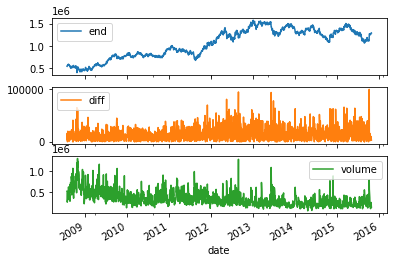

In [271]:
df.plot(subplots = True)

### 데이터를 시각화해보니 validation accuracy가 낮게 나오는 이유를 알 것 같다. 다시 범위를 설정해서 50-200페이지의 데이터를 이용해 보자

- 우리가 예측해야 하는 수치는 일단은 종가로 정했다. 따라서 dataset의 첫번째 정보인 'end'값을 이용하기 위해서 axis = 0으로 설정하였다.

#### 4-1. Single Step LSTM Layer
#### 4-1-1. Dataset 만들기
- 시계열 데이터를 예측하고자 할 때에는 이후의 과정을 일정 기간동안 예측하는 경우와 한 지점(순간)만을 예측하는 경우로 나눌 수 있다. 
- 우선 하나의 순간만을 예측하고자 한다.
- 이렇게 되면 y값의 데이터는 한개일 것이다.

In [272]:
 train_set, test_set = dataset[:trainsplit], dataset[trainsplit:]
   

make_data()함수에 들어갈 변수들에 대해서 간략한 소개를 적어본다면  
- start: 기간의 시작
- end: 기간의 끝
- past: 학습하고자하는 데이터의 값이 과거의 어느정도 인지
- future: 예측하고자 하는 값이 지금으로부터 얼마나 떨어져 있는지
- step: 이전 기간동안의 시계열 데이터를 판단할때에 6개의 데이터씩 건너가면서 학습

In [273]:
def make_data_single(dataset, target, start, end, past, future, step):
  data, label = [],[]
  start += past
  if end is None:
    end = len(dataset) - future
  for i in range(start, end):
    temp = []
    for j in range(i-past, i, step):
     temp.append(dataset[j])
    data.append(temp)
    label.append(target[i+future])
  return np.array(data), np.array(label)

In [274]:
dataset[0]

array([-1.3240387 , -0.80091324,  0.82606629])

In [275]:
x_train, y_train = make_data_single(dataset, dataset[:,0], 0, trainsplit, 100, 50, 3)
x_test, y_test = make_data_single(dataset, dataset[:,0], trainsplit, None, 100, 50,3)

In [276]:
x_test.shape

(450, 34, 3)

In [277]:
x_train.shape, y_train.shape

((1300, 34, 3), (1300,))

In [278]:
buffer = 10000
batch  = 128

In [279]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer).batch(batch).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch).repeat()

#### 4-1-2. 모델 만들기

In [280]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Dense(1))

In [281]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 32)                4608      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [282]:
model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

In [283]:
history = model.fit(train_data, steps_per_epoch = 200, epochs = 20, validation_data = test_data, validation_steps = 50)

Epoch 1/20
200/200 [==============================] - 5s 23ms/step - loss: 0.5458 - accuracy: 0.0000e+00 - val_loss: 0.3950 - val_accuracy: 0.0000e+00
Epoch 2/20
200/200 [==============================] - 4s 21ms/step - loss: 0.2533 - accuracy: 0.0000e+00 - val_loss: 0.3539 - val_accuracy: 0.0000e+00
Epoch 3/20
200/200 [==============================] - 4s 21ms/step - loss: 0.2315 - accuracy: 0.0000e+00 - val_loss: 0.3534 - val_accuracy: 0.0000e+00
Epoch 4/20
200/200 [==============================] - 4s 21ms/step - loss: 0.2146 - accuracy: 0.0000e+00 - val_loss: 0.3549 - val_accuracy: 0.0000e+00
Epoch 5/20
200/200 [==============================] - 4s 21ms/step - loss: 0.1995 - accuracy: 0.0000e+00 - val_loss: 0.3473 - val_accuracy: 0.0000e+00
Epoch 6/20
200/200 [==============================] - 4s 22ms/step - loss: 0.1889 - accuracy: 0.0000e+00 - val_loss: 0.3430 - val_accuracy: 0.0000e+00
Epoch 7/20
200/200 [==============================] - 4s 22ms/step - loss: 0.1774 - accuracy: 

In [284]:
import tensorflow.keras.backend as k
for i in range(1, len(y_test), 50):
  y_pred = model.predict(k.constant(x_train))
  print('real:{} predict:{}'.format(y_train[i],y_pred[i]))

real:-1.459964962559179 predict:[-1.0929981]
real:-1.2777002072516794 predict:[-1.2432113]
real:-0.8112260029901123 predict:[-0.70620996]
real:-0.684567444217104 predict:[-0.6042374]
real:-0.6289612476826126 predict:[-0.5835944]
real:-0.6227827814010025 predict:[-0.57837933]
real:-0.5949796831337567 predict:[-0.6384435]
real:-0.43125032667108754 predict:[-0.5090012]
real:-0.6907459104987143 predict:[-0.38005245]


#### 4-2. Multi Step LSTM
#### 4-2-1. Data 만들기

In [285]:
def make_data_multi(dataset, target, start, end, past, future, step):
  data, label = [],[]
  start += past
  if end is None:
    end = len(dataset)-future
  for i in range(start, end):
    temp = []
    for j in range(i-past, i, step):
      temp.append(dataset[j])
    data.append(temp)
    label.append(target[i:i+future])
  return np.array(data), np.array(label)

In [291]:
x_train, y_train = make_data_multi(dataset, dataset[:,0], 0, trainsplit, 400, 50,6)
x_test, y_test = make_data_multi(dataset, dataset[:,0], trainsplit, None, 400, 50, 6)

In [292]:
x_test.shape,y_test.shape,x_train.shape

((150, 67, 3), (150, 50), (1000, 67, 3))

In [293]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer).batch(batch).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_data = test_data.batch(batch).repeat()


#### 4-2-2. Model 만들기

In [302]:
model = tf.keras.models.Sequential()
#LSTM Layer
model.add(tf.keras.layers.LSTM(32, input_shape = x_train.shape[-2:]))
#다층 퍼셉트론의 DNN Layer
model.add(tf.keras.layers.Dense(32,input_dim=40,activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
for i in range(2):
    model.add(tf.keras.layers.Dense(128,activation="relu"))
    model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(50))
model.summary()
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(), metrics = ['accuracy'])

history = model.fit(train_data, validation_data = test_data, epochs = 20, steps_per_epoch=400, validation_steps = 200)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 32)                4608      
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)             

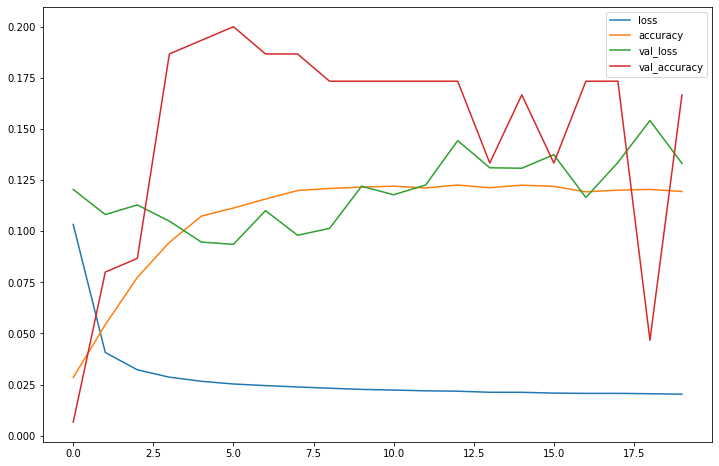

In [303]:
pd.DataFrame(history.history).plot(figsize = (12,8))

In [305]:
x_eval, y_eval = make_data_multi(dataset, dataset[:,0],100, 1700, 500, 50,6)
eval_data = tf.data.Dataset.from_tensor_slices((x_eval, y_eval))
eval_data = eval_data.batch(batch)
model.evaluate(eval_data)

9/9 [==============================] - 0s 14ms/step - loss: 0.0404 - accuracy: 0.1118


[0.040443260222673416, 0.11181817948818207]

### 5. 데이터 시각화(적절한 예측인지 확인)

In [393]:
def multistep_show(history, future, predict):
  plt.figure(figsize = (12,8))
  num_in = [int(i) for i in range(-len(history), 0)]
  num_out = len(future)
  plt.plot(num_in, np.array(history))
  plt.plot(np.arange(num_out)/3,np.array(future), 'bo', label = 'Real')
  plt.plot(np.arange(num_out)/3,np.array(predict), 'ro', label = 'Predict')

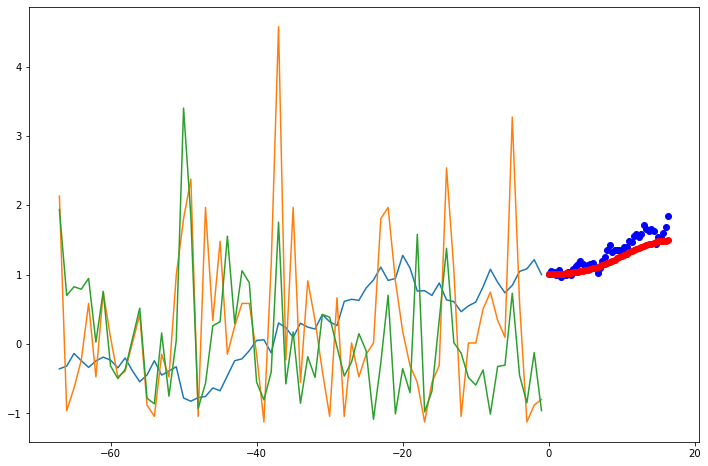

In [409]:
for x,y in train_data.take(1):
  multistep_show(x[0],y[0],model.predict(x)[0])

#### Accuracy가 그렇게 높다고 보기는 어렵지만 그래도 비교적 시각화 해 보니 얼추 원하던 추이에 수렴하는 것 같다. Epoch 수를 늘리던가 하는 방법을 시도해 보면 훨씬 나은 결과를 얻을 수 있을 것이라 생각한다.